## Sound Recognition with CONVOLUTIONAL NEURAL NETWORKS.
OBJECTIVE: Obtain a model based on a CONVOLUTIONAL NEURAL NETWORK for sound recognition. 

< SOUND RECOGNITION FOR ENVIRONMENTAL EVENT CLASSIFICATION >
 
 Asiel Aldana Ortiz 
 <asiel.aldana89@gmail.com>
 
The present <"python notebook"> was developed by Asiel Aldana Ortiz, for optimal performance it is recommended to use PC with the following minimum characteristics:
    
    - GPU or TPU 
    - 12GB RAM
    - 50 GB Disk(Available)
    
    
For this reason it is recommended to use Google Colab:
 
    -from google.colab import drive

    -drive.mount('/content/gdrive')

    -!ls



#Install matplolib 3.1.0 
!pip install matplotlib==3.1.0

In [0]:
import keras, IPython.display
import pylab
import cv2
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from datetime import datetime 
from string import ascii_uppercase
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from keras.models import Sequential
from keras import optimizers
from keras.layers import Activation, Conv2D, Flatten, Dense, Dropout, MaxPooling2D
import scipy.fftpack
import numpy as np
import pandas as pd
import librosa
import librosa.display
import random
import warnings
warnings.filterwarnings('ignore')

# UrbanSound DATASET
https://urbansounddataset.weebly.com/index.html#welcome

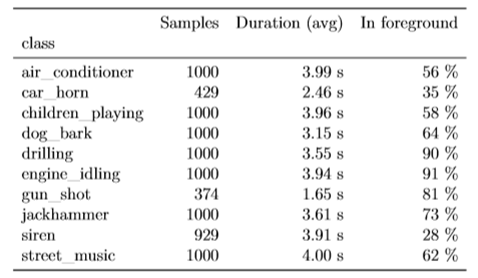



* 8732(Annotations+Records)
* <=4 Seconds
* 10 Class




## Reading Metadata(Annotations)

In [8]:
data = pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')
data.head(10)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
5,100263-2-0-143.wav,100263,71.500000,75.500000,1,5,2,children_playing
6,100263-2-0-161.wav,100263,80.500000,84.500000,1,5,2,children_playing
7,100263-2-0-3.wav,100263,1.500000,5.500000,1,5,2,children_playing
8,100263-2-0-36.wav,100263,18.000000,22.000000,1,5,2,children_playing
9,100648-1-0-0.wav,100648,4.823402,5.471927,2,10,1,car_horn


# Extract all samples larger than 2.95 seconds

In [9]:
info_ = data[['slice_file_name', 'fold' ,'classID', 'class']][ data['end']-data['start'] >= 2.95 ]  # ->(7479, 4)
info_c0 = info_[['slice_file_name', 'fold' ,'classID', 'class']][ data['classID']== 0 ] #  -> (997, 4)
info_c1 = info_[['slice_file_name', 'fold' ,'classID', 'class']][ data['classID']== 1 ] #  -> (220, 4)
info_c2 = info_[['slice_file_name', 'fold' ,'classID', 'class']][ data['classID']== 2 ] #  -> (981, 4)
info_c3 = info_[['slice_file_name', 'fold' ,'classID', 'class']][ data['classID']== 3 ] #  -> (700, 4)
info_c4 = info_[['slice_file_name', 'fold' ,'classID', 'class']][ data['classID']== 4 ] #  -> (831, 4)
info_c5 = info_[['slice_file_name', 'fold' ,'classID', 'class']][ data['classID']== 5 ] #  -> (973, 4)
info_c6 = info_[['slice_file_name', 'fold' ,'classID', 'class']][ data['classID']== 6 ] #  -> (34, 4)
info_c7 = info_[['slice_file_name', 'fold' ,'classID', 'class']][ data['classID']== 7 ] #  -> (842, 4)
info_c8 = info_[['slice_file_name', 'fold' ,'classID', 'class']][ data['classID']== 8 ] #  -> (901, 4)
info_c9 = info_[['slice_file_name', 'fold' ,'classID', 'class']][ data['classID']== 9 ] #  -> (1000,4)
info_.shape

(7479, 4)

# Folds

In [41]:
info_fold_all = []
info_fold_1= info_[['slice_file_name', 'fold' ,'classID', 'class']][ data['fold']== 1 ] 
info_fold_2= info_[['slice_file_name', 'fold' ,'classID', 'class']][ data['fold']== 2 ] 
info_fold_3= info_[['slice_file_name', 'fold' ,'classID', 'class']][ data['fold']== 3 ] 
info_fold_4= info_[['slice_file_name', 'fold' ,'classID', 'class']][ data['fold']== 4 ] 
info_fold_5= info_[['slice_file_name', 'fold' ,'classID', 'class']][ data['fold']== 5 ] 
info_fold_6= info_[['slice_file_name', 'fold' ,'classID', 'class']][ data['fold']== 6 ] 
info_fold_7= info_[['slice_file_name', 'fold' ,'classID', 'class']][ data['fold']== 7 ] 
info_fold_8= info_[['slice_file_name', 'fold' ,'classID', 'class']][ data['fold']== 8 ] 
info_fold_9= info_[['slice_file_name', 'fold' ,'classID', 'class']][ data['fold']== 9 ] 
info_fold_10= info_[['slice_file_name', 'fold' ,'classID', 'class']][ data['fold']== 10 ] 
info_fold_1.shape

(755, 4)

In [24]:
# Example 
#sr = 22050 Hz
# t(s)= hop_lennght/sr
# fM = n_mels
# shape(t,fM) = 128x128
y, sRate = librosa.load('UrbanSound8K/audio/fold5/100263-2-0-121.wav', duration=2.95)
msp = librosa.feature.melspectrogram(y=y, sr=sRate,hop_length=512,n_mels=128)
msp = librosa.power_to_db(msp, ref=np.max)
msp.shape
 

(128, 128)

In [25]:
IPython.display.Audio(y, rate=sRate)

In [0]:
N = sRate
T = 1.0 / sRate
x = np.linspace(0.0, N*T, N)
yf = scipy.fftpack.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N/2)


# SIGNAL REPRESENTATION(feature extraction)

♪ Amplitude/Time

♪ Amplitude/Frequency

♪ Frequency/Time

# ♪♪♪ Amplitude/Time ♪♪♪

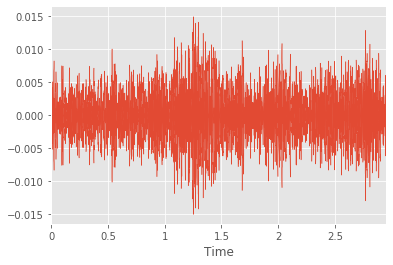

In [27]:
plt.style.use("ggplot")
librosa.display.waveplot(y, sr=sRate)

# ♪♪♪ Amplitude/Frequency ♪♪♪

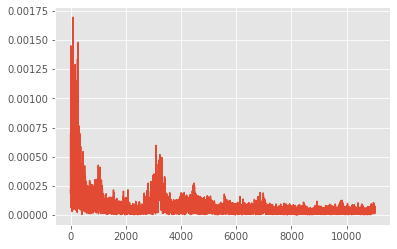

In [28]:
fig, ax = plt.subplots()
ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))

# Mel-frequency cepstrum:
Mel-frequency cepstrum (MFC) is a representation of the short-time power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency.

# MFCCs
Mel-frequency cepstral coefficients (MFCCs) are coefficients that collectively make up an MFC.

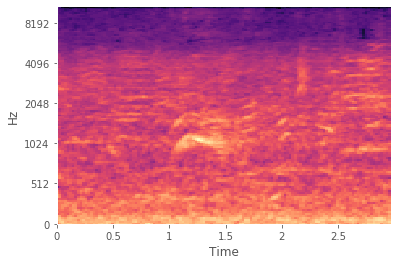

In [29]:
librosa.display.specshow(msp, y_axis='mel', x_axis='time')

# ♪♪♪ Frequency/Time ♪♪♪

# Generator "Path"

In [43]:
info_['path'] = 'fold' + info_['fold'].astype('str') + '/' + info_['slice_file_name'].astype('str')
info_c6['path'] = 'fold' + info_['fold'].astype('str') + '/' + info_['slice_file_name'].astype('str') # Aumetando data Class #6

info_fold_1['path'] = 'fold' + info_fold_1['fold'].astype('str') + '/' + info_fold_1['slice_file_name'].astype('str')
info_fold_2['path'] = 'fold' + info_fold_2['fold'].astype('str') + '/' + info_fold_2['slice_file_name'].astype('str')
info_fold_3['path'] = 'fold' + info_fold_3['fold'].astype('str') + '/' + info_fold_3['slice_file_name'].astype('str')
info_fold_4['path'] = 'fold' + info_fold_4['fold'].astype('str') + '/' + info_fold_4['slice_file_name'].astype('str') 
info_fold_5['path'] = 'fold' + info_fold_5['fold'].astype('str') + '/' + info_fold_5['slice_file_name'].astype('str') 
info_fold_6['path'] = 'fold' + info_fold_6['fold'].astype('str') + '/' + info_fold_6['slice_file_name'].astype('str')
info_fold_7['path'] = 'fold' + info_fold_7['fold'].astype('str') + '/' + info_fold_7['slice_file_name'].astype('str')
info_fold_8['path'] = 'fold' + info_fold_8['fold'].astype('str') + '/' + info_fold_8['slice_file_name'].astype('str')
info_fold_9['path'] = 'fold' + info_fold_9['fold'].astype('str') + '/' + info_fold_9['slice_file_name'].astype('str')
info_fold_10['path'] = 'fold' + info_fold_10['fold'].astype('str') + '/' + info_fold_10['slice_file_name'].astype('str')

info_fold_1.shape

(755, 5)

In [31]:
info_

,slice_file_name,fold,classID,class,path
1,100263-2-0-117.wav,5,2,children_playing,fold5/100263-2-0-117.wav
2,100263-2-0-121.wav,5,2,children_playing,fold5/100263-2-0-121.wav
3,100263-2-0-126.wav,5,2,children_playing,fold5/100263-2-0-126.wav
4,100263-2-0-137.wav,5,2,children_playing,fold5/100263-2-0-137.wav
5,100263-2-0-143.wav,5,2,children_playing,fold5/100263-2-0-143.wav
...,...,...,...,...,...
8724,99812-1-0-1.wav,7,1,car_horn,fold7/99812-1-0-1.wav
8725,99812-1-0-2.wav,7,1,car_horn,fold7/99812-1-0-2.wav
8726,99812-1-1-0.wav,7,1,car_horn,fold7/99812-1-1-0.wav
8727,99812-1-2-0.wav,7,1,car_horn,fold7/99812-1-2-0.wav


In [32]:
len(info_[0:len(info_)])

7479

# Upload data(If the image data was generated it is not necessary to roll this cell)

THE FOLLOWING CELL IS EXECUTED ONLY ONCE (WAS WRITTEN TO EXECUTE PREPROCESSING AND UPLOAD DATA (IMAGES GENERATED FROM AUDIO) IN MEMORY)


1. Load audio file (2.95 sec duration).
2. Computa MFC (128 features).
3. Convert power spectrum to decibels.
4. Save the generated spectrum image.
5. Open the generated image (with resize (128x128)) and store it with the new size.







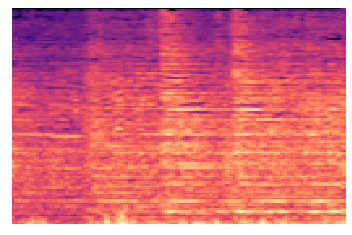

In [48]:
Dato_tr = [] 
data_tr = info_fold_1  #info_[0:7000]  

# Upload data(Google Drive Asiel_2)
for row in data_tr.itertuples():
    y, sRate = librosa.load('UrbanSound8K/audio/' + row.path, duration=2.95)  
    msp =librosa.feature.melspectrogram(y=y, sr=sRate,hop_length=512,n_mels=128)
    msp = librosa.power_to_db(msp, ref=np.max)
    filename = 'UrbanSound8K/audio/' + row.path.replace('.wav','.jpg')   # For MFCC ->    filename = 'UrbanSound8K/audio/' + row.path.replace('mfcc.wav','.jpg')
    librosa.display.specshow(msp)

    plt.savefig(filename,dpi = None, bbox_inches='tight',pad_inches=-0.1)
    img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
 
    # Shape image
    width = 128 
    height = 128 
    dim = (width, height)

    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    cv2.imwrite(filename,resized)
    if resized.shape != (128, 128): continue
    Dato_tr.append( (resized, row.classID) )

print("Total samples read(Train): ", len(Dato_tr))
plt.close('all')

# Data augmentation(If the image data was generated it is not necessary to roll this cell)


*   Time Stretch(https://www.youtube.com/watch?v=V8OVltlJ_CY)

This technique can be used to transpose an audio sample while holding speed or duration constant. This may be accomplished by time stretching and then resampling back to the original length. Alternatively, the frequency of the sinusoids in a sinusoidal model may be altered directly, and the signal reconstructed at the appropriate time scale.



Total samples read:  1


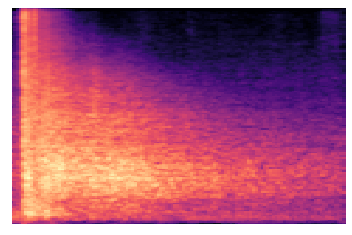

In [19]:
rate = 1.08 # para 0.82, 0.94  -> 90 increased samples
inf_ts = info_c6[0:1]  # iterar para -> inf_ts = info_c6[0:30] 
Data_ts = []

for row in inf_ts.itertuples():
    y1, sRate = librosa.load('UrbanSound8K/audio/' + row.path, duration=2.95)  
    y_changed = librosa.effects.time_stretch(y1, rate=rate)
    filename = 'UrbanSound8K/audio/' + row.path.replace('.wav','TS108_c6.wav')  # For MFCC ->    filename = 'UrbanSound8K/audio/' + row.path.replace('TS108_c6mfcc.wav','.jpg')
    librosa.output.write_wav(filename,y_changed, sRate)
    
    filename_img = 'UrbanSound8K/audio/' + row.path.replace('.wav','TS108_c6.jpg')

    y, sRate = librosa.load(filename, duration=2.95)  
    msp =librosa.feature.melspectrogram(y=y, sr=sRate,hop_length=512,n_mels=128)
    msp = librosa.power_to_db(msp, ref=np.max)

    librosa.display.specshow(msp)
    plt.savefig(filename_img,dpi = None, bbox_inches='tight',pad_inches=-0.1)
    img = cv2.imread(filename_img, cv2.IMREAD_UNCHANGED)

    # Size image
    width = 128 
    height = 128 
    dim = (width, height)

    # Resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    cv2.imwrite(filename_img,resized)
    if resized.shape != (128, 128,3): continue
    Data_ts.append( (resized, row.classID) )

print("Total samples read: ", len(Data_ts))

# Time Stretch_122690-6-0-0.wav
*  Original




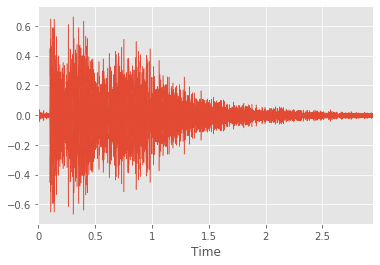

In [0]:
librosa.display.waveplot(y1, sr=sRate)

# Time Stretch_122690-6-0-0TS108_c6.wav

*  Obtained

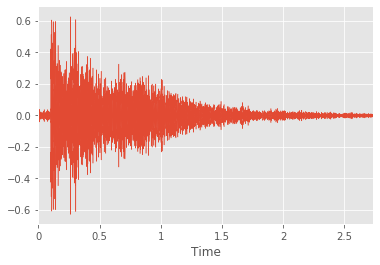

In [0]:
librosa.display.waveplot(y, sr=sRate)

# Upload image(Pitch Shift) If the image data was generated it is not necessary to roll this cell

*   Pitch Shift(https://www.youtube.com/watch?v=s2t29H2PpOY)

From a musical point of view, pitch shifting consists of shifting a melody by one or many semitones up or down.


Total samples read:  1


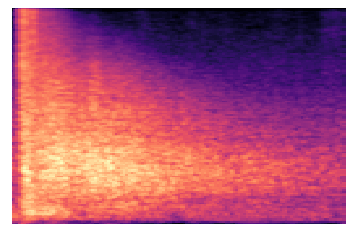

In [20]:
n_steps = 2   #−2, −1, 1 ->120 increased samples
inf_ps = info_c6[0:1]  # iterar para -> inf_ps = info_c6[0:30] 
Data_ps = []

for row in inf_ps.itertuples():
    y1, sRate = librosa.load('UrbanSound8K/audio/' + row.path, duration=2.95)  
    y_changed =librosa.effects.pitch_shift(y1, sRate, n_steps=n_steps)
    filename = 'UrbanSound8K/audio/' + row.path.replace('.wav','PS2_c6.wav')
    librosa.output.write_wav(filename,y_changed, sRate)
    
    filename_img = 'UrbanSound8K/audio/' + row.path.replace('.wav','PS2_c6.jpg')

    y, sRate = librosa.load(filename, duration=2.95)  
    msp =librosa.feature.melspectrogram(y=y, sr=sRate,hop_length=512,n_mels=128)
    msp = librosa.power_to_db(msp, ref=np.max)

    librosa.display.specshow(msp)
    plt.savefig(filename_img,dpi = None, bbox_inches='tight',pad_inches=-0.1)
    img = cv2.imread(filename_img, cv2.IMREAD_UNCHANGED)

    # Size image
    width = 128 
    height = 128 
    dim = (width, height)

    # Resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    cv2.imwrite(filename_img,resized)
    if resized.shape != (128, 128,3): continue
    Data_ps.append( (resized, row.classID) )


# Pitch Shift_122690-6-0-0mfccPS2_c6.wav
*  Original

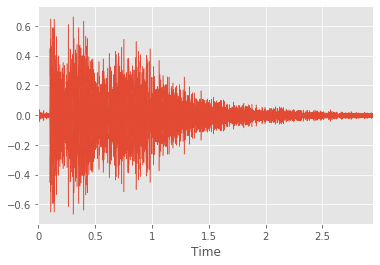

In [21]:
librosa.display.waveplot(y1, sr=sRate)

# Pitch Shift_122690-6-0-0mfccPS2_c6.wav
*  Original

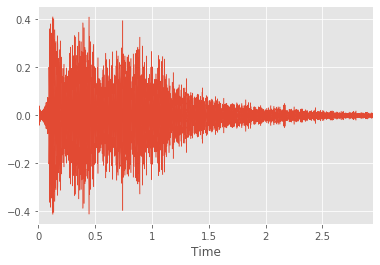

In [22]:
librosa.display.waveplot(y, sr=sRate)

# LOAD DATA

*  During the implementation phase of the model, two functions were developed to load the data (stored images). It was divided into TRAIN and TEST.
*  Before increasing data, the amount of data chosen was 7000 samples (Train-Val) and 479 (Test), separating 10% of the set (Train-Val) for Validation.





In [0]:
# Load data(Train/Val)  
Dato_tr1 = [] 
data_tr =  info_[0:7000]  # info_[0:7000] or  adding each fold  <info_fold_x> Ex: Train-> info_fold_1-info_fold_9 and Test info_fold_10

for row in data_tr.itertuples():
  filename = 'UrbanSound8K/audio/' + row.path.replace('.wav','.jpg')  #filename = 'UrbanSound8K/audio/' + row.path.replace('mfcc.wav','.jpg')
  img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
  if img.shape != (128, 128,3): continue
  Dato_tr1.append( (img, row.classID )) #, row.classID)
print("Total samples read(Train/Val): ", len(Dato_tr1)) 

In [29]:
# Load data(Test) 
Dato_t = [] 
data_t = info_fold_10  #info_[7000:7479]

for row in data_t.itertuples():
    filename = 'UrbanSound8K/audio/' + row.path.replace('.wav','T.jpg')
    img_t = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
    if img_t.shape != (128, 128,3): continue
    Dato_tr1.append( (img_t, row.classID )) #, row.classID)
print("Total samples read(Test): ", len(Dato_tr1))

Total samples read(Test):  7479


# Separate training data and test 

In [359]:
random.shuffle(Dato_tr1)
Data_train = Dato_tr1[0:7000]
#random.shuffle(Dato_t)
test = Dato_tr1[7000:7479]
X_test, y_test = zip(*test)
len(test)

479

In [360]:
y_test.count(6)

3

In [361]:
dataset = Data_train

X_, y_ = zip(*dataset)
X_train, X_val, y_train, y_val = train_test_split(X_,y_,test_size = 0.10)

len(X_val)


700

In [362]:
y_train.count(6)

28

In [363]:
y_val.count(6)

3

In [0]:
# Reshape input
X_train = np.array([x.reshape( (128, 128, 3) ) for x in X_train])
X_val = np.array([x.reshape( (128, 128, 3) ) for x in X_val])
X_test = np.array([x.reshape( (128, 128, 3) ) for x in X_test])

# Data Normalization 
X_train = X_train/255
X_val = X_val/255
X_test =X_test/255

# One-Hot encoding 
y_train1 = np.array(keras.utils.to_categorical(y_train, 10))
y_val1 = np.array(keras.utils.to_categorical(y_val, 10))
y_test1 = np.array(keras.utils.to_categorical(y_test, 10))



In [58]:
model = Sequential()
input_shape=(128, 128, 3)

model.add(Conv2D(24, (4, 4), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))
model.add(Activation('relu'))

model.add(Conv2D(32, (4, 4), padding="valid"))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))
model.add(Activation('relu'))

model.add(Conv2D(32, (4, 4), padding="valid"))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (4, 4), padding="valid"))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(10))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 125, 125, 24)      1176      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 62, 62, 24)        0         
_________________________________________________________________
activation_35 (Activation)   (None, 62, 62, 24)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 59, 59, 32)        12320     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 29, 29, 32)        0         
_________________________________________________________________
activation_36 (Activation)   (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 26, 26, 32)       

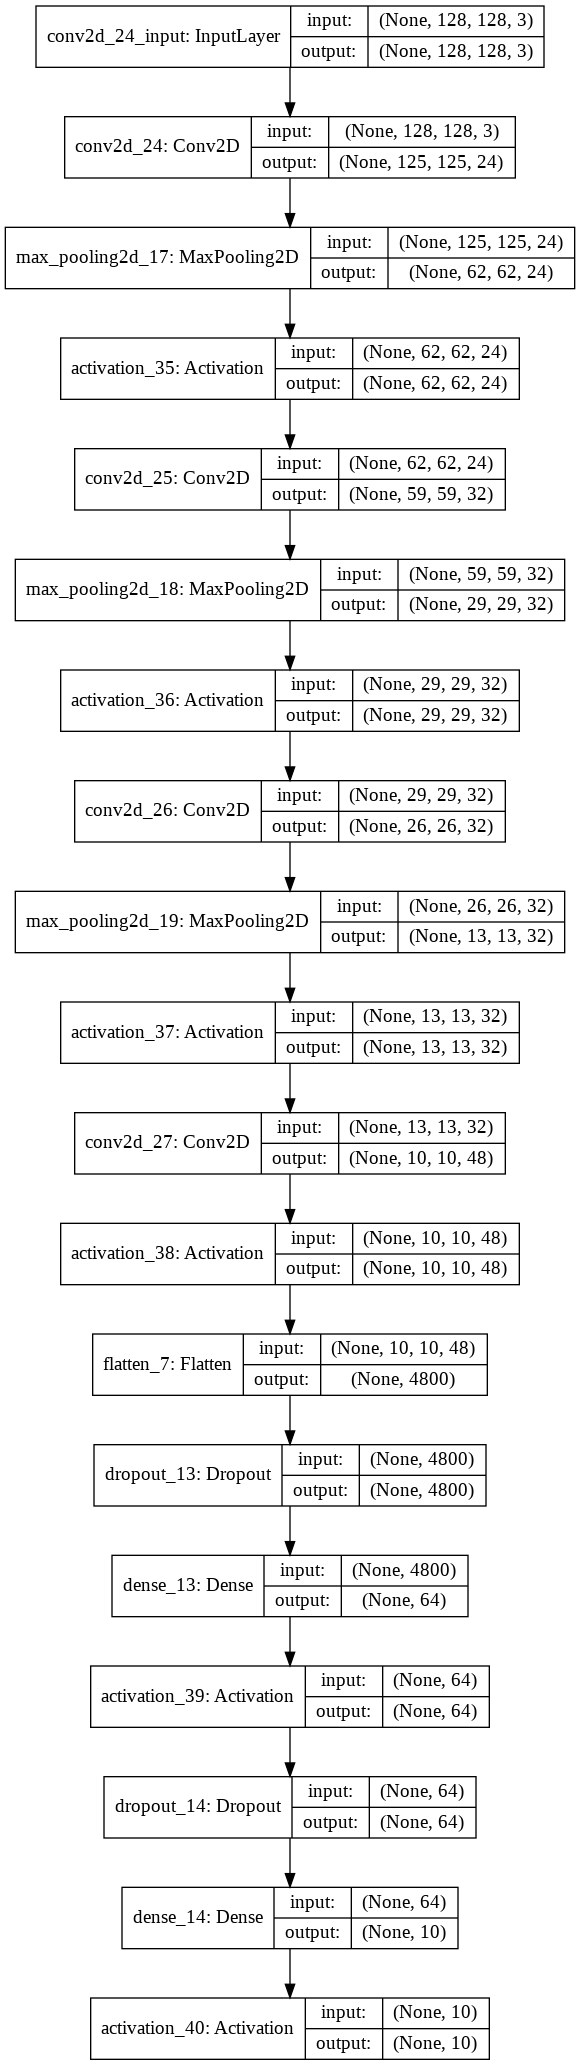

In [59]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [375]:
INIT_LR = 1e-3  # 1e-2
epochs_val = 55  # 20
batch_size_val = 100


#sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#keras.optimizers.Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
#keras.optimizers.Adagrad(lr=INIT_LR, decay=INIT_LR / 100)
#opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

checkpointer = ModelCheckpoint(filepath='My_Model/weights_CNN_mfc.hdf5', 
                               verbose=1, save_best_only=True)

model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adamax(lr=INIT_LR, beta_1=0.9, beta_2=0.999),metrics=['accuracy'])

start = datetime.now()

history = model.fit(x=X_train, y=y_train1, epochs = epochs_val,
          batch_size = batch_size_val, validation_data= (X_val, y_val1),callbacks=[checkpointer], verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

score = model.evaluate(	x=X_test,	y=y_test1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 6300 samples, validate on 700 samples
Epoch 1/55
6300/6300 [==============================] - 9s 1ms/step - loss: 2.1200 - acc: 0.1795 - val_loss: 1.9236 - val_acc: 0.2714

Epoch 00001: val_loss improved from inf to 1.92359, saving model to My_Model/weights_CNN_mfc.hdf5
Epoch 2/55
6300/6300 [==============================] - 5s 826us/step - loss: 1.9134 - acc: 0.2798 - val_loss: 1.7702 - val_acc: 0.3700

Epoch 00002: val_loss improved from 1.92359 to 1.77016, saving model to My_Model/weights_CNN_mfc.hdf5
Epoch 3/55
6300/6300 [==============================] - 5s 815us/step - loss: 1.7899 - acc: 0.3368 - val_loss: 1.6474 - val_acc: 0.4200

Epoch 00003: val_loss improved from 1.77016 to 1.64736, saving model to My_Model/weights_CNN_mfc.hdf5
Epoch 4/55
6300/6300 [==============================] - 5s 817us/step - loss: 1.7056 - acc: 0.3743 - val_loss: 1.5460 - val_acc: 0.4229

Epoch 00004: val_loss improved from 1.64736 to 1.54600, saving model to My_Model/weights_CNN_mfc.hdf5
Epo

<function matplotlib.pyplot.show>

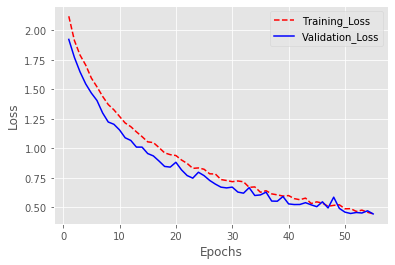

In [376]:
# Training and Val History (LOSS)
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Count of Epochs
epochs_count = range(1, len(train_loss)+1) 

# Show Loss history
plt.style.use("ggplot")
plt.figure()
plt.plot(epochs_count,train_loss, 'r--')
plt.plot(epochs_count,val_loss, 'b-')
plt.legend(['Training_Loss','Validation_Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show

<function matplotlib.pyplot.show>

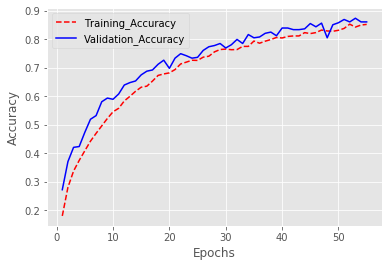

In [377]:
# Training and Val History (Accuracy)
train_acc = history.history['acc']
val_acc = history.history['val_acc']

# Count of Epochs
epochs_count = range(1, len(train_loss)+1) 

# Show Accuracy history
plt.style.use("ggplot")
plt.figure()
plt.plot(epochs_count,train_acc, 'r--')
plt.plot(epochs_count,val_acc, 'b-')
plt.legend(['Training_Accuracy','Validation_Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show

In [378]:
score

[0.4618090449643782, 0.8371607499480994]

# Predictions(Test set)

In [379]:
predictions = model.predict(X_test)
i = 0
j = 0
y_True = []
y_Pred = []

for i in y_test: 
 y_True.append(i)
 y_Pred.append(np.argmax(predictions[j]))
 j = j+1

y_Pred[0]


4

In [381]:
y_True[0]

0

# Confusion matrix 

<Figure size 432x288 with 0 Axes>

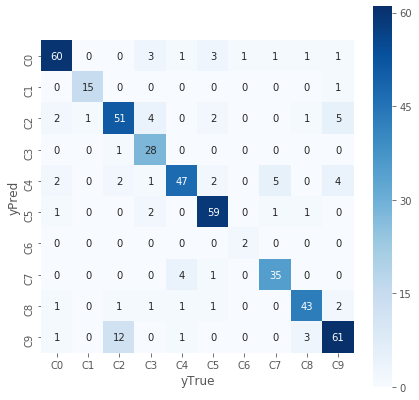

In [382]:
y_True = np.array(y_True)  #[1,2,3,5,6,7,8,9,0,4]y_True
y_Pred = np.array(y_Pred)   #[1,2,3,5,6,7,8,9,0,4]  y_Pred
cmap = plt.get_cmap('Blues')

CM = confusion_matrix(y_Pred,y_True)
class_name = ['C0','C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
df_cm = pd.DataFrame(CM, index = class_name, columns = class_name)

plt.tight_layout()
plt.figure(figsize=(7, 7))
plt.imshow(CM, interpolation='nearest', cmap=cmap)
Graph = sns.heatmap(df_cm, cmap = plt.get_cmap('Blues'), annot= True)
Graph.set(xlabel= 'yTrue', ylabel='yPred')
plt.show()

In [383]:
precision_score(y_True, y_Pred, average=None)

array([0.84507042, 0.9375    , 0.77272727, 0.96551724, 0.74603175,
       0.921875  , 1.        , 0.875     , 0.86      , 0.78205128])

In [384]:
recall_score(y_True, y_Pred, average=None)

array([0.89552239, 0.9375    , 0.76119403, 0.71794872, 0.87037037,
       0.86764706, 0.66666667, 0.83333333, 0.87755102, 0.82432432])

In [385]:
f1_score(y_True, y_Pred, average=None)

array([0.86956522, 0.9375    , 0.76691729, 0.82352941, 0.8034188 ,
       0.89393939, 0.8       , 0.85365854, 0.86868687, 0.80263158])